In [123]:
# Processing experiments around the ROI 
# coding: utf-8

import sys
import os

from pprint import pprint
from collections import OrderedDict

sys.path.insert(0, './src/')

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

from matplotlib import animation
from matplotlib.ticker import MaxNLocator
from IPython.display import HTML
from scipy import ndimage
from skimage.filters import roberts
from skimage.filters import sobel
from skimage.filters import prewitt, prewitt_h, prewitt_v

from FRAPanalyzer.lifproc import LIFContainer
from FRAPanalyzer.lifproc import start_bioformats
from FRAPanalyzer.lifproc import stop_bioformats
from processing import Processing, win_gaus, win_average

Opening wrapper for bioformats

In [124]:
start_bioformats()

BioContainer started


Loading experiment *.lif* file

In [125]:
lif = LIFContainer('./test_data/Experiment_001.lif')

Looking for a structure in wrapped object

In [126]:
lif.lif_img_data

OrderedDict([('Image005',
              {'C': 3, 'ID': 'Image:0', 'T': 1, 'X': 512, 'Y': 512, 'Z': 1}),
             ('FRAP/FRAP Series09',
              {'C': 2, 'ID': 'Image:1', 'T': 127, 'X': 128, 'Y': 128, 'Z': 1}),
             ('FRAP_004/FRAP Series16',
              {'C': 1, 'ID': 'Image:2', 'T': 369, 'X': 64, 'Y': 64, 'Z': 1}),
             ('FRAP/FRAP Series18',
              {'C': 1, 'ID': 'Image:3', 'T': 787, 'X': 64, 'Y': 64, 'Z': 1})])

Selecting series of images

In [127]:
series_id = 'FRAP_004/FRAP Series16'

Loading images to numpy array

In [128]:
img = lif.get_full_array(series_id, progressbar=True)

100%|██████████| 369/369 [00:23<00:00, 15.72it/s]


In [129]:
# Example of how to load full experiment array
# NOW: this approach was included inside the the lif package therefore no reason to use it
# but if you wanna see only raw data in array format this approach will be useful for you
# img = wrp.get_full_array('FRAP_001/FRAP Series10')
# series_name = 'FRAP_001/FRAP Series10'

print(lif.lif_img_data[series_id])
current_series_id = lif.lif_series_order.index(series_id)

{'C': 1, 'T': 369, 'Y': 64, 'X': 64, 'Z': 1, 'ID': 'Image:2'}


In [130]:
# dimensionality reduction
# one experiment should consist of series single pictures
img = img[:,:,0,:]

# check the correctness 
img.shape

(64, 64, 369)

In [131]:
# Customizations

save_video_experiments = True

t = 60
x_, y_ = 33.0, 28.5 # the centre of bleach region
R = 17 # the radious of bleach redion
t_last = 61

### Visualization of bleaching

<IPython.core.display.Javascript object>


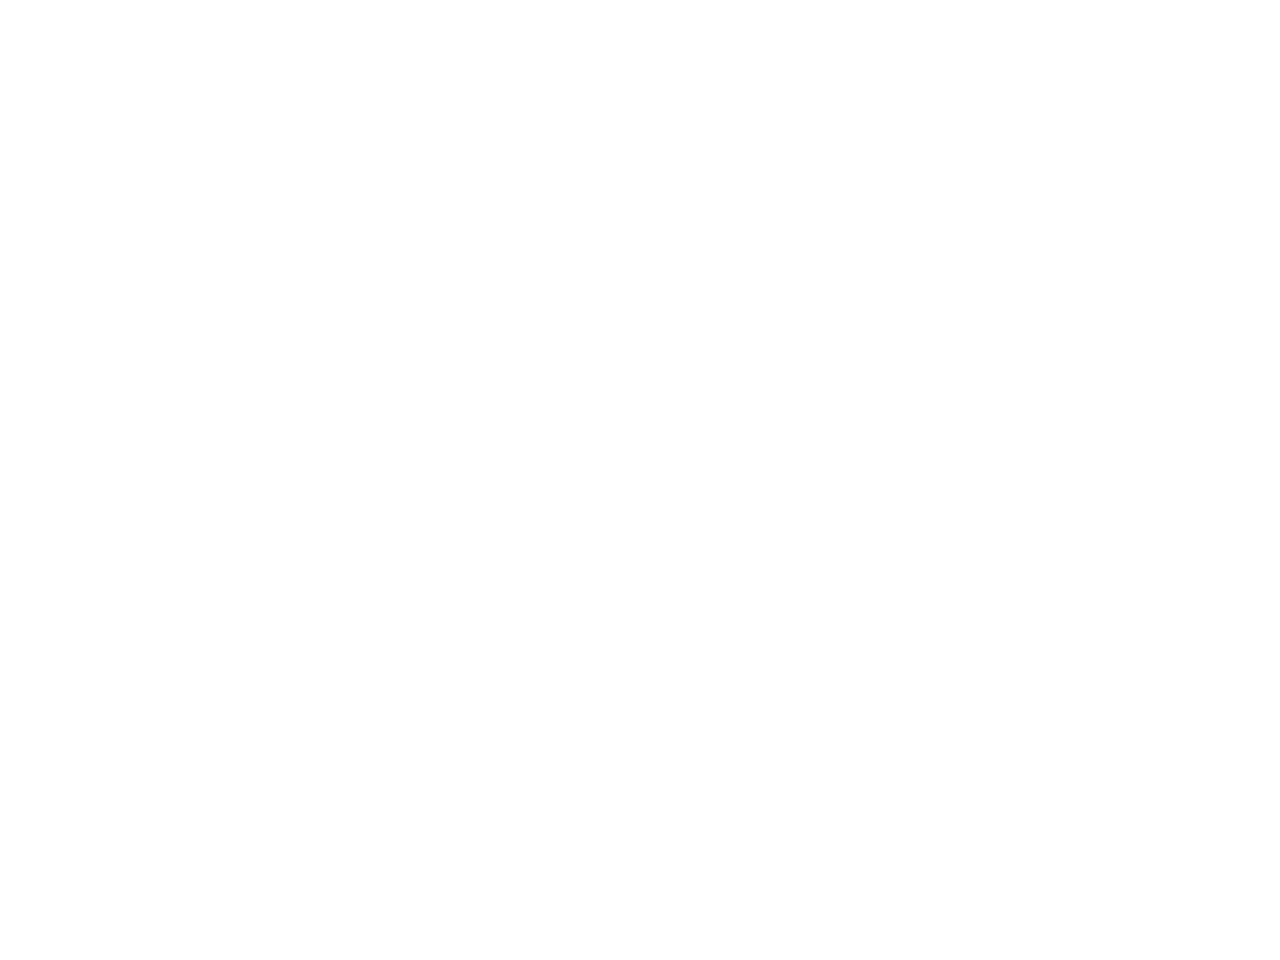

IndexError: index 369 is out of bounds for axis 2 with size 369

In [141]:
# prebleach 0-1, bleach 1 - 60 , after-bleach 61

# contour around the ROI
# just int value contour
    
fig = plt.figure()
ax = plt.imshow(img[:,:,0])    
    
def f_border(a, edge=int):
    return np.array([edge(e) for e in a])
    
def init():
    ax.set_data(np.zeros_like(img[:,:, 0]))
    return ax,
    
def animate(i): 
    
    i = img.shape[-1] if i > t_last else i
    
    t = np.linspace(0, np.pi * 2, img.shape[-1])
    x = x_ + R * np.sin(t)
    y = y_ + R * np.cos(t)
    x, y = f_border(x), f_border(y)
    ax.set_data(img[:, :, i])
    return ax,

anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=img.shape[-1],
    blit=True, interval=100, repeat=False
)

if save_video_experiments:
    anim.save('basic_animation_experiment.mp4', fps=2, extra_args=['-vcodec', 'libx264'])

# Experiments

### Applying sobel filters to images
explonation of sobel filter
![sobel_explonatino](http://people.ece.cornell.edu/land/courses/ece5760/FinalProjects/s2013/cwf38_as889_mao65/images/sobel_convolution.png)

### Visualization of sobel filter components
 where Gx - horizontal filter and Gy - vertical filter and Sobel filter is G
 
The experiment results show that there is a sense to consider a convolution of the coordinates to understand the weight each of value (each direction). The video shows that the weights of horizontal component stronger (both positive and negative aspects of component) that shown as dark color. Consequently, on the resulting filter this effect can be observed.

In [142]:
from skimage.filters import (sobel_h, sobel_v)

sh_frames = np.zeros(img.shape[:2] + (t_last,))
sv_frames = np.zeros(img.shape[:2] + (t_last,))
sob_frames = np.zeros(img.shape[:2] + (t_last,))

ph_frames = np.zeros(img.shape[:2] + (t_last,))
pv_frames = np.zeros(img.shape[:2] + (t_last,))
prew_frames = np.zeros(img.shape[:2] + (t_last,))

for i in range(t_last,):
    sh_frames[:,:,i] = sobel_h(img[:,:,i])
    sv_frames[:,:,i] = sobel_v(img[:,:,i])
    sob_frames[:,:,i] = np.sqrt(sh_frames[:,:,i]**2 + sv_frames[:,:,i]**2)
    sob_frames[:,:,i] /= np.sqrt(2)
    
    ph_frames[:,:,i] = prewitt_h(img[:,:,i])
    pv_frames[:,:,i] = prewitt_v(img[:,:,i])
    prew_frames[:,:,i] = np.sqrt(ph_frames[:,:,i]**2 + pv_frames[:,:,i]**2)
    prew_frames[:,:,i] /= np.sqrt(2)    

In [143]:
sh_avg, sv_avg, sob_avg = win_average(sh_frames, n=5), win_average(sv_frames, n=5), win_average(sob_frames, n=5)
ph_avg, pv_avg, prew_avg = win_average(ph_frames, n=5), win_average(pv_frames, n=5), win_average(prew_frames, n=5)

<IPython.core.display.Javascript object>


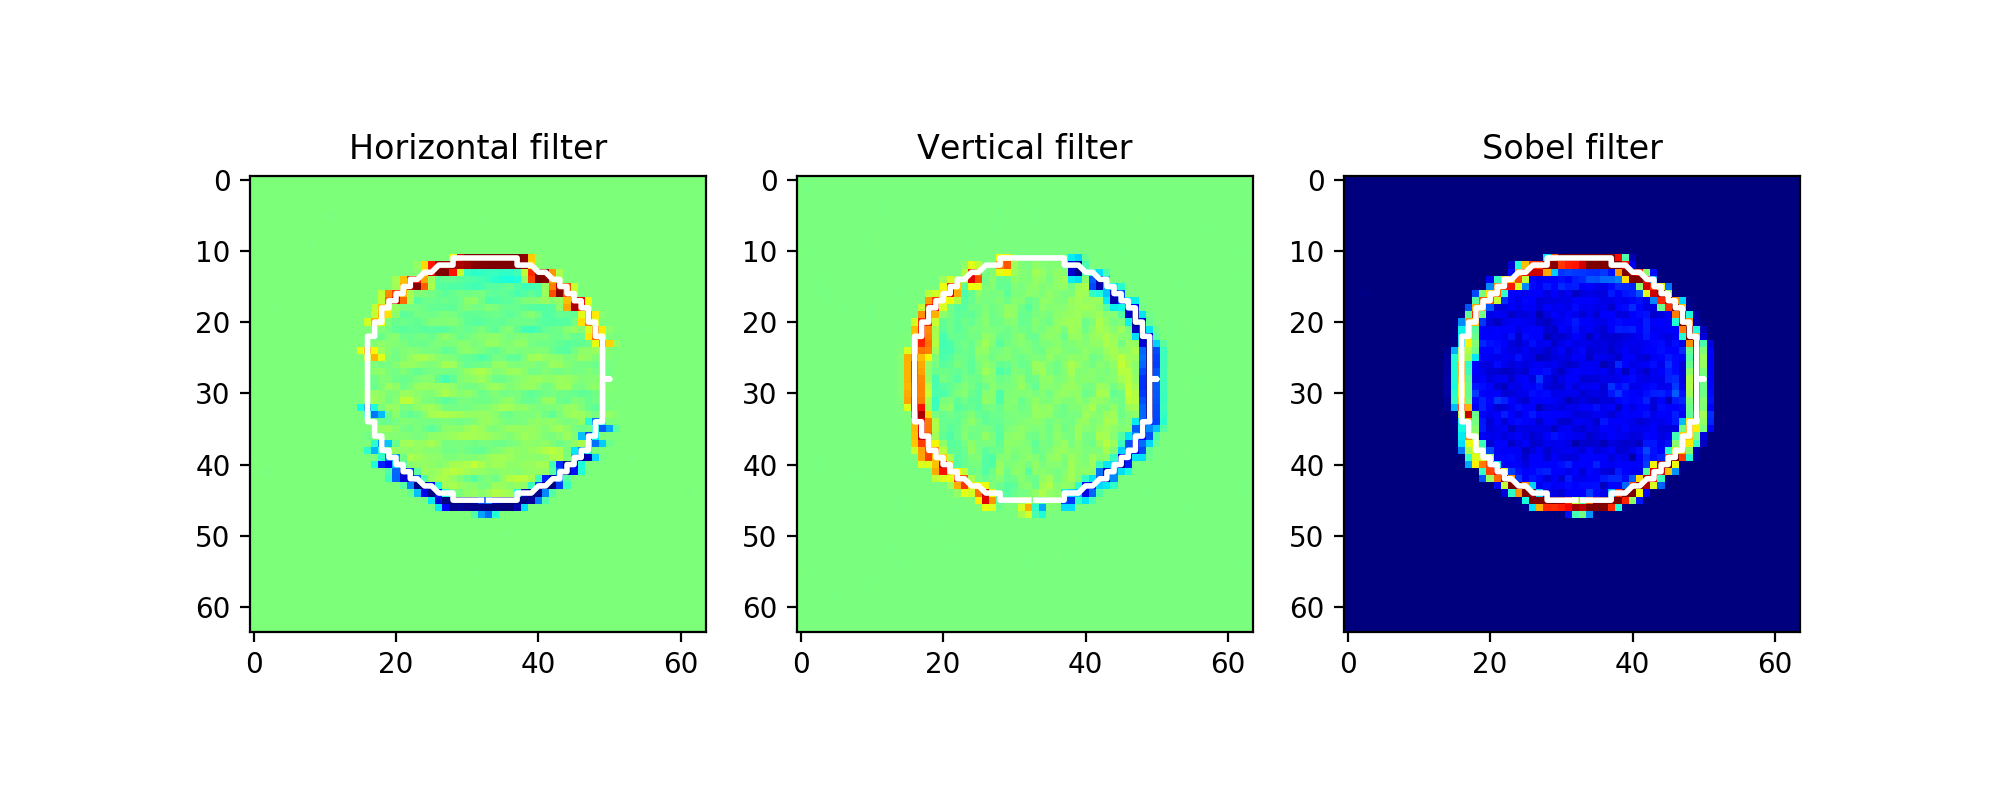

In [144]:
t = np.linspace(0, np.pi * 2, img.shape[-1])
x, y = x_ + R * np.sin(t), y_ + R * np.cos(t)
x, y = f_border(x), f_border(y)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.set_title('Horizontal filter')
ax2.set_title('Vertical filter')
ax3.set_title('Sobel filter')

h1 = ax1.imshow(sh_avg[:,:,0], cmap=plt.cm.jet)
h2 = ax2.imshow(sv_avg[:,:,0], cmap=plt.cm.jet)
h3 = ax3.imshow(sob_avg[:,:,0], cmap=plt.cm.jet)

ax1.plot(x, y, color='w', linewidth=2.0)
ax2.plot(x, y, color='w', linewidth=2.0)
ax3.plot(x, y, color='w', linewidth=2.0)

def init():
    h1.set_data(np.zeros_like(sh_avg[:,:,0]))
    h2.set_data(np.zeros_like(sv_avg[:,:,0]))
    h3.set_data(np.zeros_like(sob_avg[:,:,0]))
    return h1, h2, h3

def animate(i):
    h1.set_data(sh_avg[:,:,i])
    h2.set_data(sv_avg[:,:,i])
    h3.set_data(sob_avg[:,:,i])
    return h1, h2, h3

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=sv_avg.shape[-1], interval=20, blit=True)

if save_video_experiments:
    anim.save('basic_animation_sobel.mp4', fps=2, extra_args=['-vcodec', 'libx264'])

<IPython.core.display.Javascript object>


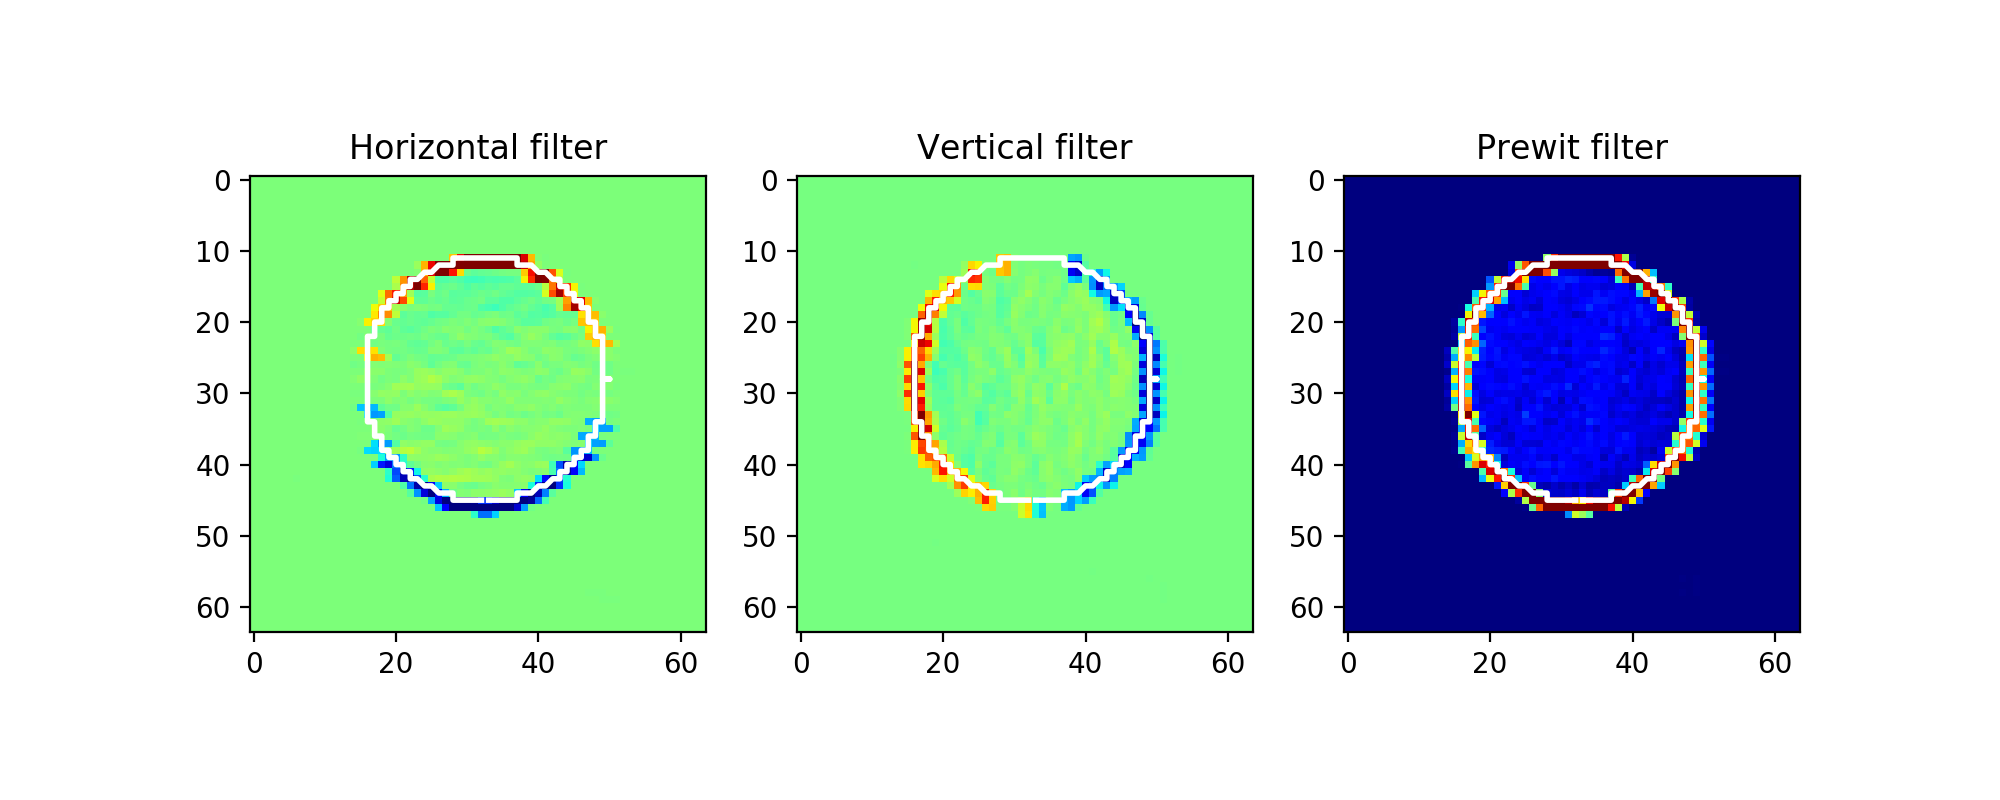

In [145]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

titles = ['Horizontal filter', 'Vertical filter', 'Prewit filter']
for i, ax in enumerate(axs):
    ax.set_title(titles[i])

hs = [axs[0].imshow(ph_avg[:,:,0], cmap=plt.cm.jet), axs[1].imshow(pv_avg[:,:,0], cmap=plt.cm.jet),
      axs[2].imshow(prew_avg[:,:,0], cmap=plt.cm.jet)]

for ax in axs:
    ax.plot(x, y, color='w', linewidth=2.0)

arrs = [ph_avg, pv_avg, prew_avg]
def init():
    for i, h in enumerate(hs):
        h.set_data(np.zeros_like(arrs[i][:,:,0]))
    return tuple(hs)

def animate(i):
    for ind, h in enumerate(hs):
        h.set_data(arrs[ind][:,:,i])
    return tuple(hs)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=sv_avg.shape[-1], interval=20, blit=True)
if save_video_experiments:
    anim.save('basic_animation_prewitt.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

# Gaussian for image
![gaussian](http://campar.in.tum.de/twiki/pub/Chair/HaukeHeibelGaussianDerivatives/gauss2d00.png)

in this case we wanna make filter that will count the max weight for the center pixel in the mask, in other words it is a simple convolution with max weight in the center of mask. 
![gaussian_explonation](https://www.researchgate.net/profile/Yasuaki_Ito/publication/294424568/figure/fig12/AS:330299767574530@1455761009308/Figure-4-Illustrating-a-window-of-size-m-m-a-Gaussian-filter-of-size-2w-1-2w.png)

### Visualization of Gaussian + (Sobel, Roberts, Prewitt) edge detection

Experiment steps:
- manual bleaching border tuning (choose R, (x, y) - centre of bleaching area)
- Gaussian averaging on the images
- Sobel, Roberts, Prewitt filter

Experiment results:
- the application of Sobel filter shows general direction of gradient diff - we can observe the region of grafdient diff. This trend can be observed with all sigmas.
- the application of Roberts filter shows more sensetive behaviour to gradient diff. It illustrates the wave behaviour (if changes are significant it can be clearly seen by color)
- the application of Prewitt filter illustrates significant gradient diff in small Gaussian sigma context and made it better than Sobel filter

Результаты эксперимента: 
- Применения фильтра Собеля отображает общее движение (направление) градиента в каждый момент времени, можно наблюдать лишь область, в которой градиент меняется сильнее всего. Тенденцию можно прослеживать при любой сигме. 
- Применение фильтра Робертса позволяет увидеть более точечные изменения, но неравномерное изменение - всплески не позволяют интропретирвоать резульаты. По мере увеличения сигмы результаты становятся более похожими на применение Собеля
- Применение фильтра Превита хорошо иллюстрирует значительные изменения градиента при использовании малой сигмы - точнее, чем фильтр Собеля.

<IPython.core.display.Javascript object>


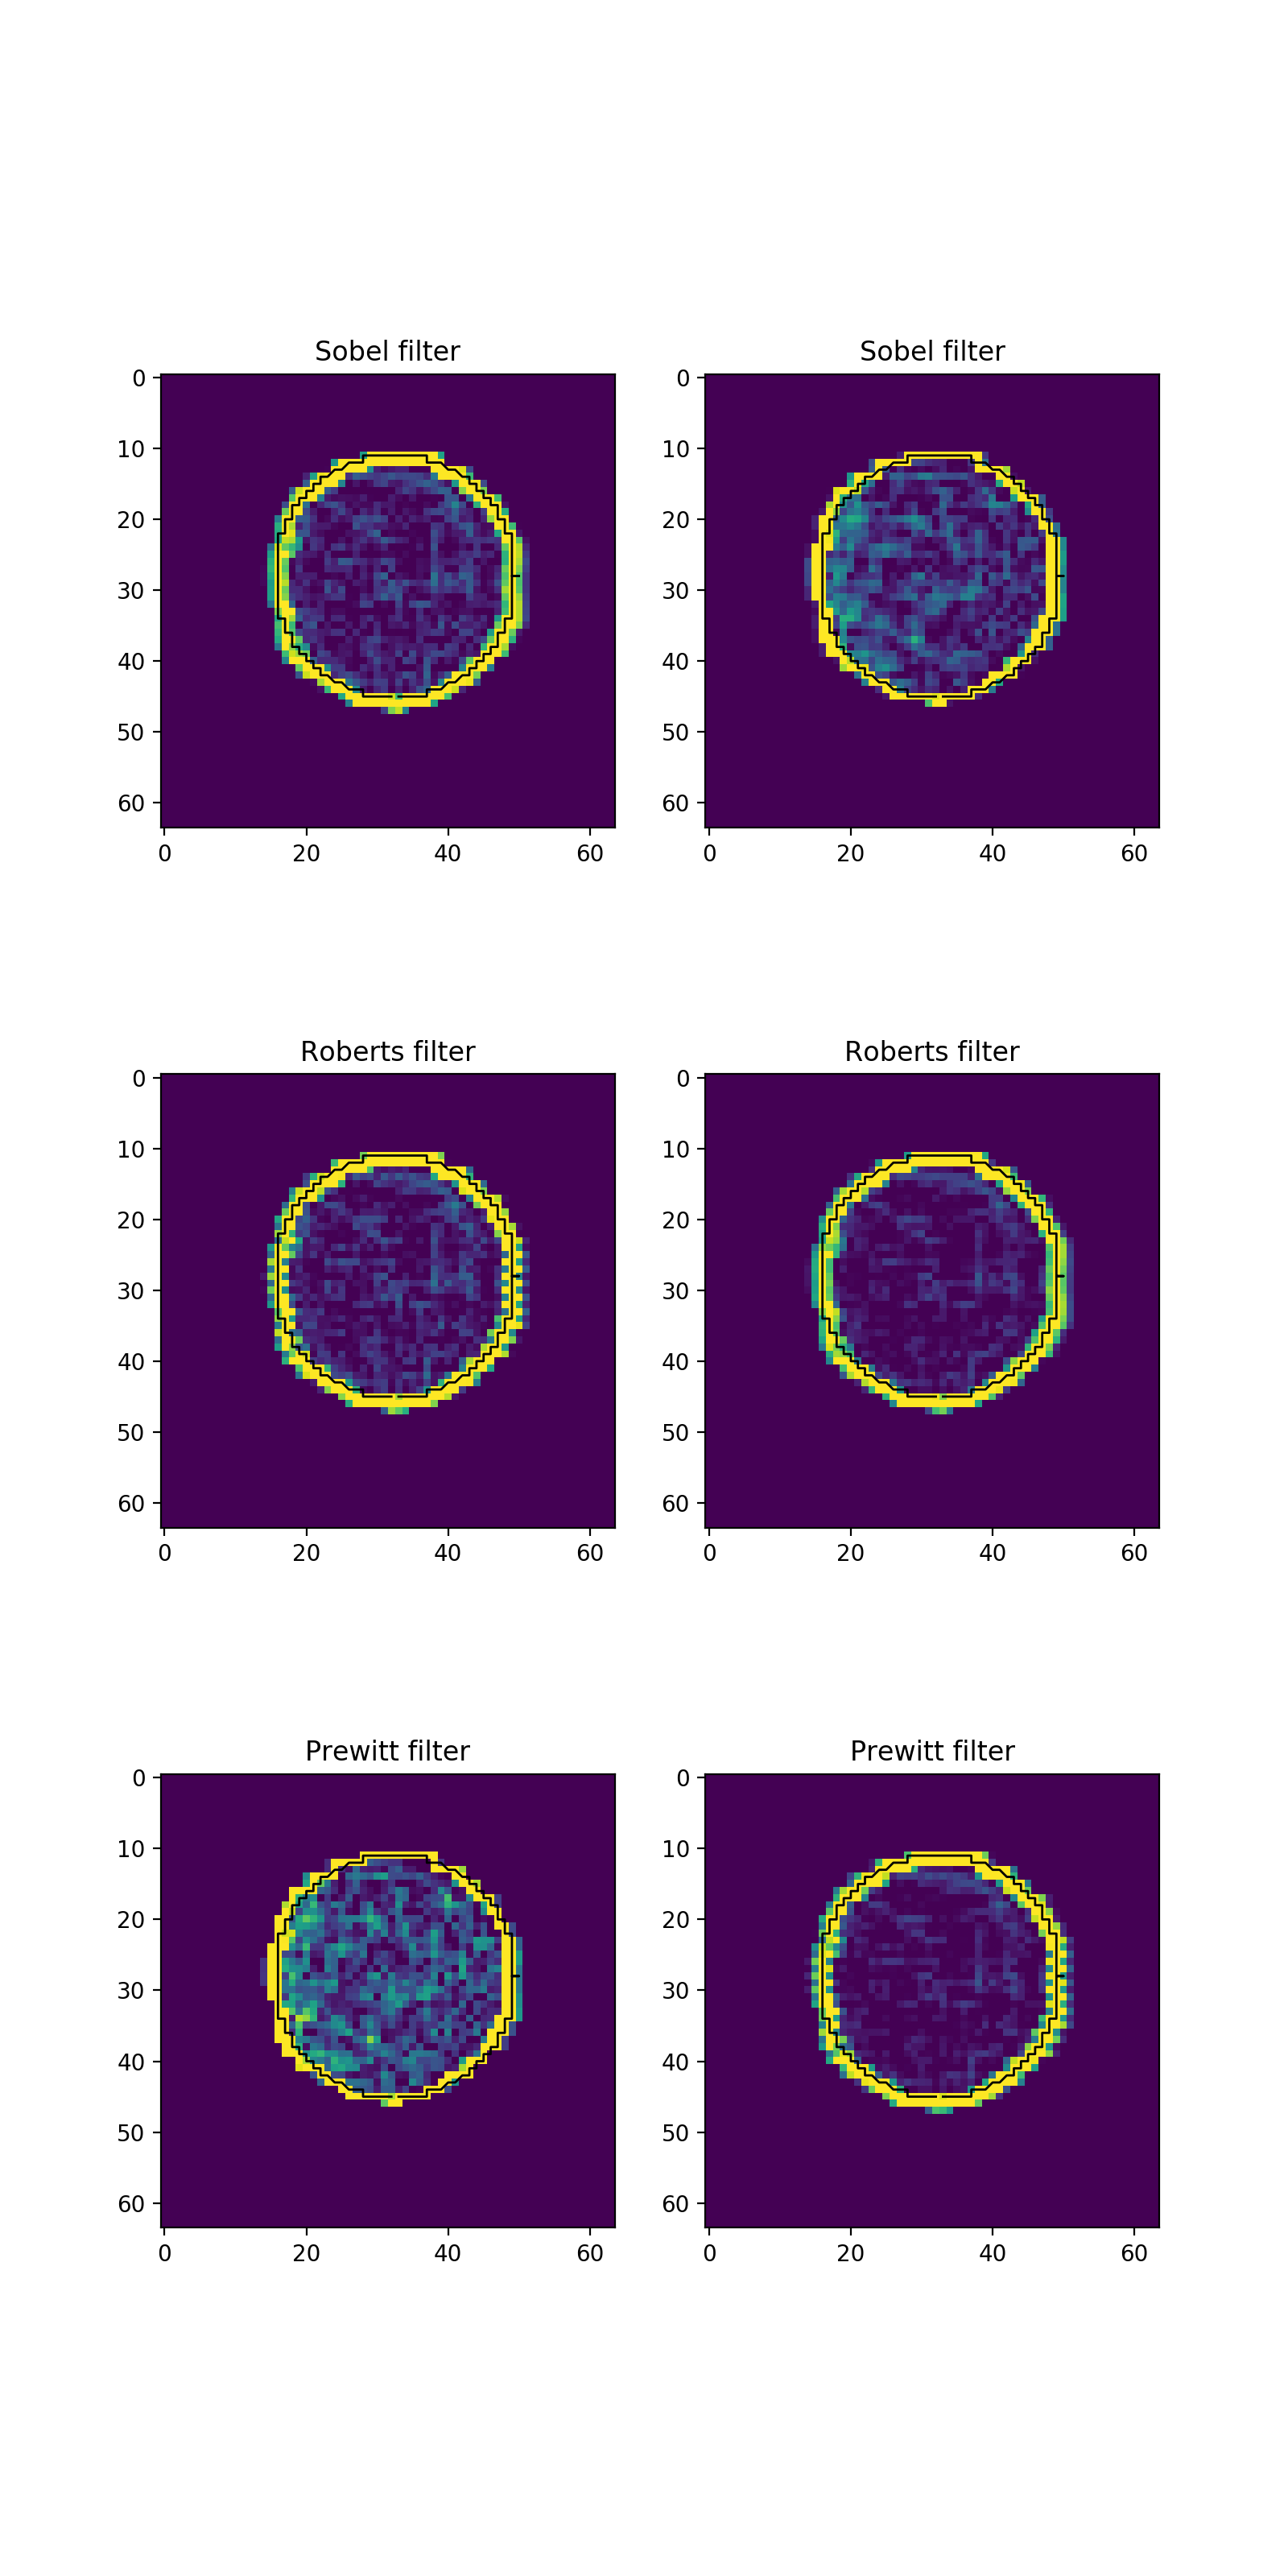

In [146]:
gaussian_sigma = 0.1

img_gaus = np.array(
    map(lambda img: ndimage.gaussian_filter(img, sigma=gaussian_sigma, mode='wrap'), img)
)

sigmas = [0.1, 0.5]
img_gaus_list = []
for s in sigmas:
    img_gaus_list.append(
        np.array(
            map(lambda img: ndimage.gaussian_filter(img, sigma=s, mode='wrap'), img)
        )
    )

fig, (ax_sobel, ax_roberts, ax_prewitt) = plt.subplots(3, 2, figsize=(8, 16))

titles = ['Sobel filter', 'Roberts filter', 'Prewitt filter']
filters = [sobel, roberts, prewitt]
hs = []
for i, axs in enumerate([ax_sobel, ax_roberts, ax_prewitt]):
    for ax_ in axs:
        ax_.set_title(titles[i])
        ax_.plot(x, y, color='black', linewidth=1.0)
        hs.append(ax_.imshow(img_gaus[:,:,0]))

def init():
    for h in hs:
        h.set_data(np.zeros_like(img[:,:,0]))
    return tuple(hs)

def animate(i): 
        
    for ind, h in enumerate(hs):
        image = img_gaus_list[ind % 2][:,:, i]
        edge = filters[ind % 3](image)
        h.set_data(edge)
    
    return tuple(hs)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=t_last, interval=20, blit=True)

if save_video_experiments:
    anim.save('basic_animation_filters.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

we are estimating the gradient inside the space between provided ROI and actual maximum gradient front. 
Trying to average gradient (after construction) around the the configured ROI border.

![separation](https://image.ibb.co/fNaqKa/kek_2.png)

In [60]:
def edge_grad(img, func, kwargs):
    """
    function that makes possible to use any edge detection algorithms
    :param min_R: (max_R - min_R) / separation_count - po for future smoothing
    :param max_R: (max_R - min_R) / separation_count - po for future smoothing
    :separation_count: (max_R - min_R) / separation_count - po for future smoothing
    """
    diff_grad = []
    
    min_boudary = kwargs.get('min_R', 16.7)
    max_boundary = kwargs.get('max_R', 17.3)
    R = (max_boundary + min_boudary) / 2.
    
    separation_count = kwargs.get('separation_count', 10)
    img_count = kwargs.get('img_count', img.shape[-1])

    for R in np.linspace(min_boudary, max_boundary, separation_count):
        local_diff_grad = []
        for i in range(img_count):
            image = img[:,:, i]
            edge_func = func(image)

            t = np.linspace(0, np.pi * 2, img_count)
            x, y = x_ + R * np.sin(t), y_ + R * np.cos(t)
    
            local_diff_grad.append([])
            for xl, yl in zip(x, y):
                local_diff_grad[i].append(edge_func[int(xl), int(yl)])
            
        diff_grad.append(local_diff_grad)
    diff_grad = np.array(diff_grad).sum(axis=0) / separation_count
    return diff_grad

creating an experiment, assembling all parts of processing pipline together in one method

Experiment steps:
- manual bleaching border tuning (choose R, (x, y) - centre of bleaching area)
- Gaussian (linear) averaging on the images
- Sobel, Roberts, Prewitt filter
- Gaussian (linear) averaging of edge detection 

The main purpose of last experiment step is to detect direction of gradient diff. 
Experiment results:

Экспериментальные результаты: 
Достаточно сложно определить какую - то метрику, которая будет оценивать изменение градиента, если необходимо найти только регионы, в которых изменение градиента максимальное - то есть общее направление градиента, то достаточно использовать любой фильтр с аккуратно подобранными коэффициентами для усреднения изображений. Если же стоит задача поиска точечных изменений градиента, что является наиболее интересной задачей, то в такой случае достаточно результатов первого эксперимента (например фильтр Превита с маленькой сигмой для усреднения элементов в окне), так как результаты данного эксперимента сложнее интропретировать из - за большего количества параметров из - за отсутсвия разумных автоматических метрик качества.  

In [149]:
proc = Processing()

def make_experiment(single_filter, roi_imgs, smooth_func=None, win_func=win_gaus, **kwargs):
    
    """
    full experiment function 
    smooth function -> edge detection filter -> averaging by gaussian
    """
    
    smooth_sigma = kwargs.pop('smooth_sigma', 0.3)
    if not smooth_func:
        _frames = proc.process_single_filter(roi_imgs, single_filter)
    else:
        
        roi_imgs_smooth = map(lambda img: smooth_func(img, sigma=smooth_sigma), roi_imgs)
        _frames = proc.process_single_filter(
            np.array(roi_imgs_smooth),
            single_filter
        )
        
    n = kwargs.get('n', 5)
    
    av_roi_img = map(lambda ar: win_gaus(ar, **kwargs), [_frames])

    print np.array(av_roi_img).shape
    return av_roi_img


    
prepared_imgs = make_experiment(
    single_filter=roberts,
    win_func=win_gaus,
    smooth_func=ndimage.gaussian_filter,
    roi_imgs=img,
    n=3,
    smooth_sigma=0.1,
    sigma=1,
    truncate=3
)[0]

np.array(prepared_imgs).shape;


(1, 64, 64, 367)


<IPython.core.display.Javascript object>


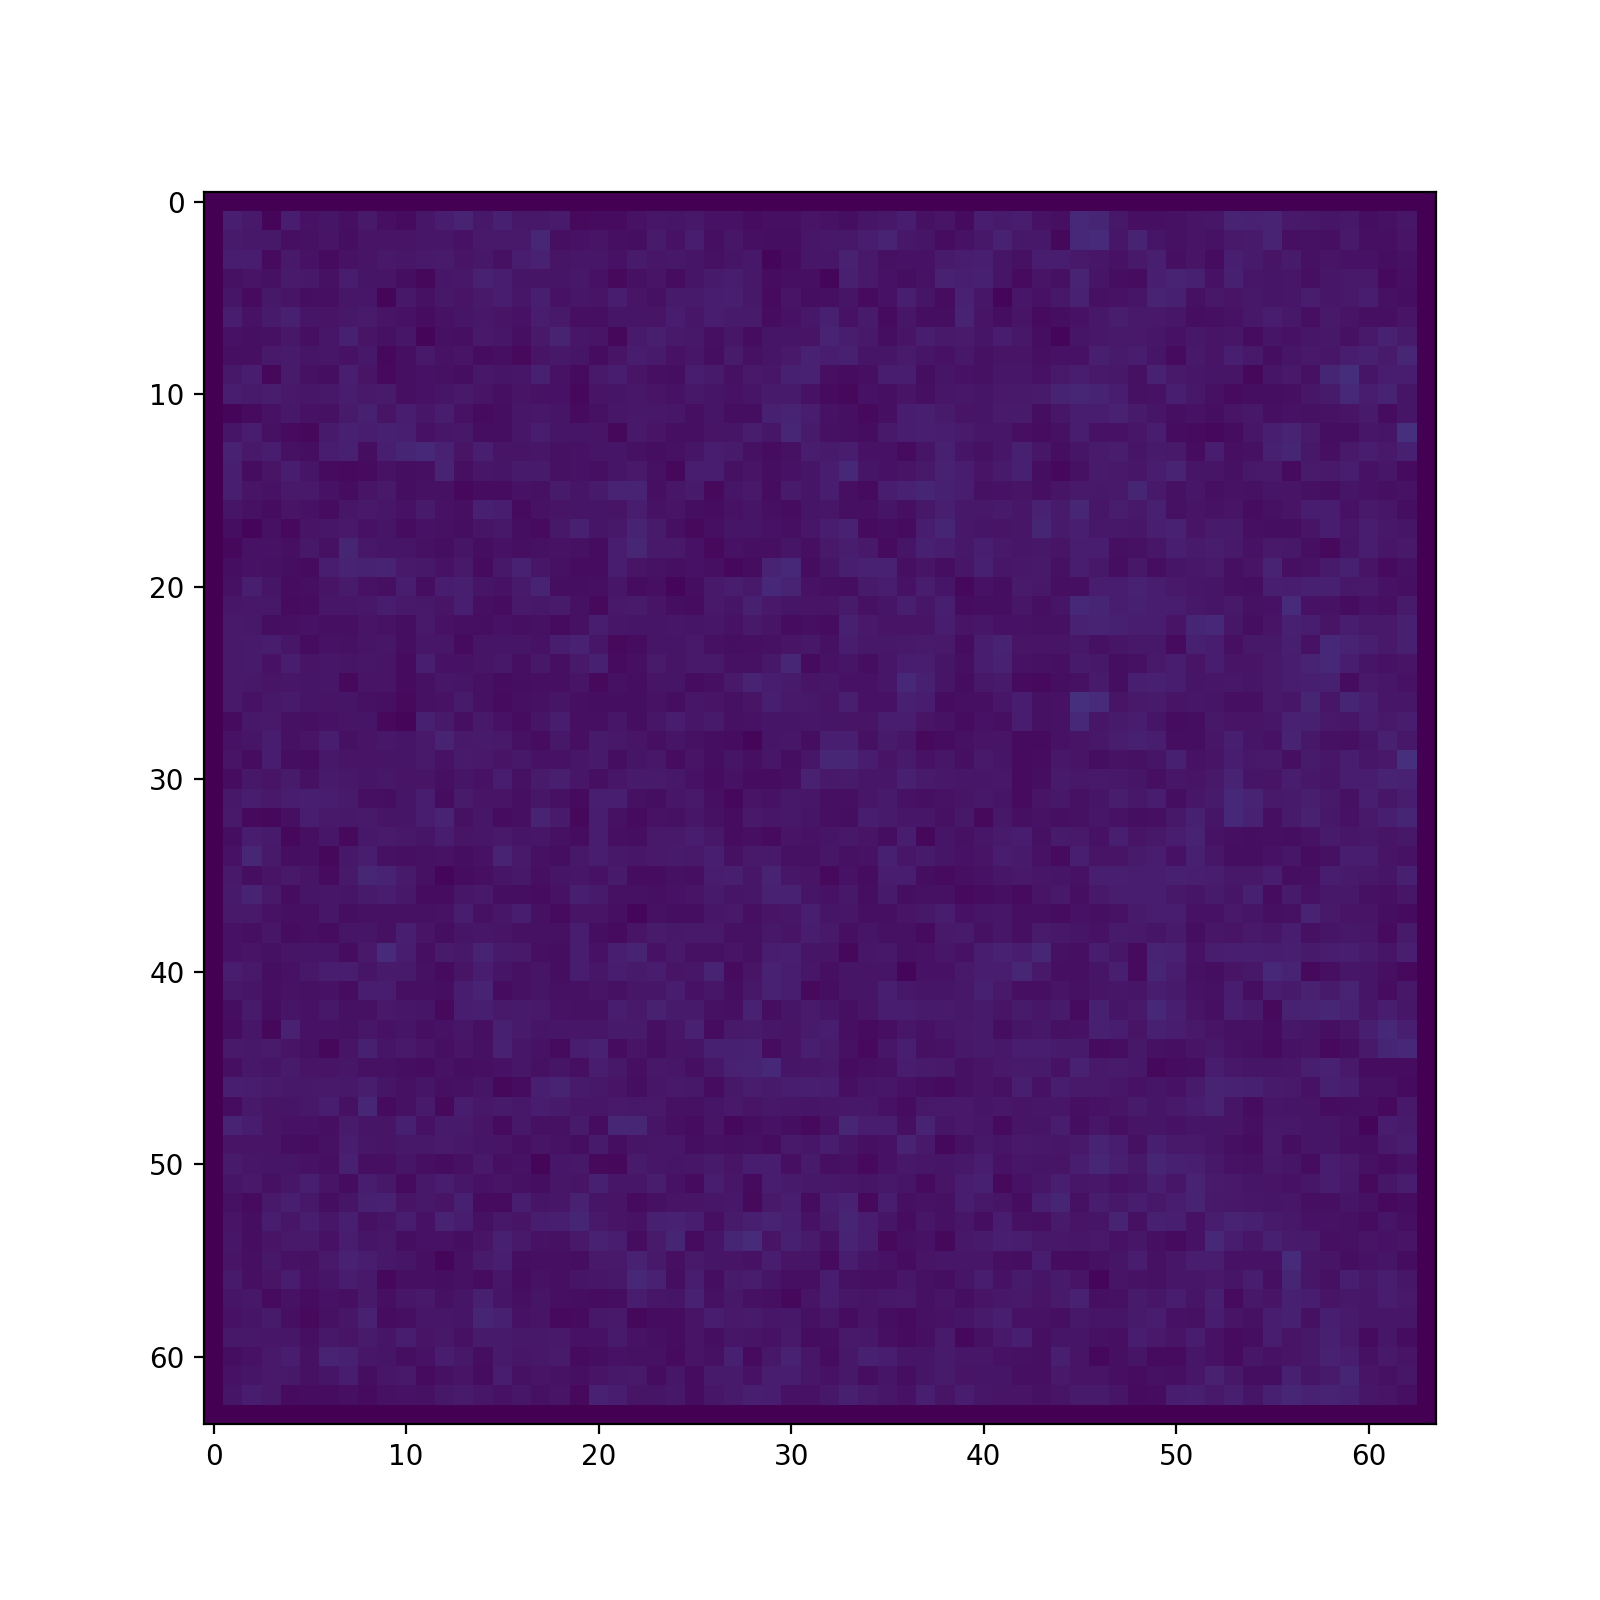

In [150]:
fig, ax = plt.subplots(figsize=(8, 8))
h = ax.imshow(prepared_imgs[:,:,0])

def init():
    h.set_data(np.zeros_like(prepared_imgs[:,:, 0]))
    return h,

def animate(i):
    h.set_data(prepared_imgs[:,:,i])
    return h,

anim = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init, interval=25, blit=True)
if save_video_experiments:
    anim.save('animation_gaus_roberts_gaus.mp4', fps=2, extra_args=['-vcodec', 'libx264'])

Searching for a better fit - an actual ROI border

In [151]:
%%time

diff_grad_sobel = edge_grad(
    img, 
    sobel,
    {
        'min_R': 16.5,
        'max_R': 17.5,
        'separation_count': 20,
        'img_count': img.shape[-1],
        't': 60
    }
)

diff_grad_roberts = edge_grad(
    img, 
    roberts,
    {
        'min_R': 16.7,
        'max_R': 17.4,
        'separation_count': 50,
        'img_count': img.shape[-1],
        't': 60
    }
)

diff_grad_prewitt = edge_grad(
    img, 
    prewitt,
    {
        'min_R': 16.4,
        'max_R': 17.4,
        'separation_count': 30,
        'img_count': img.shape[-1],
        't': 60
    }
)


diff_grad_gaus_sobel = edge_grad(
    img, 
    sobel,
    {
        'min_R': 16.4,
        'max_R': 17.4,
        'separation_count': 30,
        'img_count': img_gaus.shape[-1],
        't': 60
    }
)

assert diff_grad_sobel.shape == (369, 369)
assert diff_grad_roberts.shape == (369, 369)
assert diff_grad_prewitt.shape == (369, 369)

CPU times: user 24.7 s, sys: 970 ms, total: 25.7 s
Wall time: 26.1 s


In [152]:
# STANDARD ANIMATED PLOT
def standard_plot(diff_grad, save=None):
    fig, ax = plt.subplots()
    x = np.arange(len(diff_grad[0]))
    line, = ax.plot(x, diff_grad[0])

    def animate(i):
        line.set_ydata(diff_grad[i])  # update the data
        return line,

    # Init only required for blitting to give a clean slate.
    def init():
        line.set_ydata(np.ma.array(x, mask=True))
        return line,

    ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                                  interval=25, blit=True)
    if save:
        ani.save(save, fps=30, extra_args=['-vcodec', 'libx264'])
        
    plt.show()

comparing different combinations of filters and smoothing kernels

Результаты экспериментов: 
Одной из наиболее разумных идей - использовать сравнение абсолютных величин вычисления градиента
Так как разумных автоматических метрик качества найти не удалось, то для наглядности кривые вычисление градиента были наложены на полярные координаты. В такой интропретации легко заметить пики, что соответсвует общему направлению изменения градиента 
Также можно наблюдать рваные кривые, что отображает локальные изменения и шум (предположительно в большей части это шум)

<IPython.core.display.Javascript object>


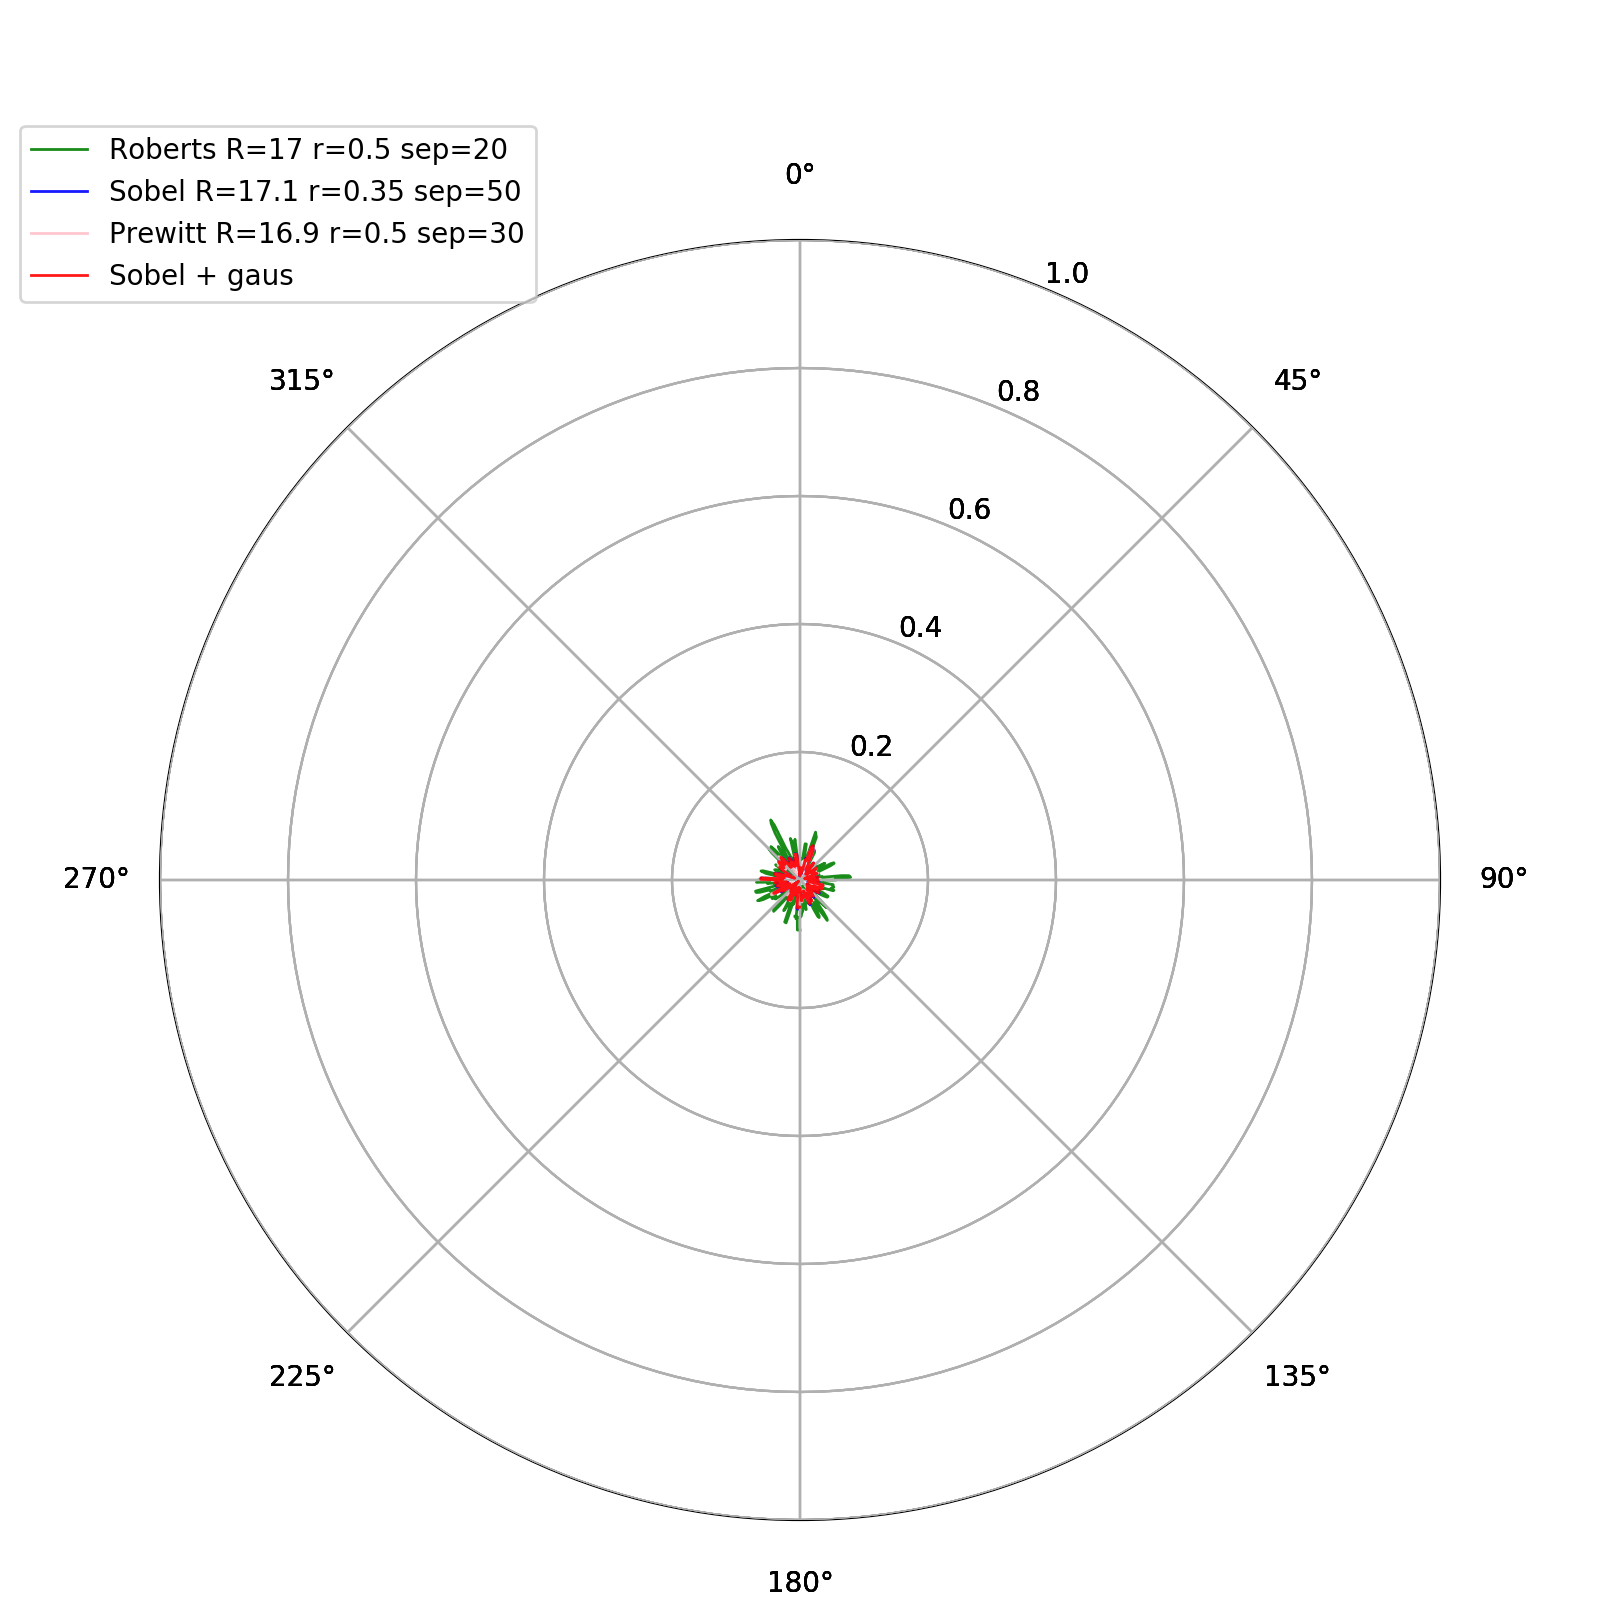

In [153]:
# implementation of visualisation

def data_gen():
    x = np.arange(-180.0, 190.0, 370 / img.shape[-1])[:img.shape[-1]]
    theta = (np.pi / 180.0 ) * x    # in radians 
    for i in xrange(img.shape[-1]):
        yield (theta, diff_grad_roberts[i], diff_grad_sobel[i], diff_grad_prewitt[i], diff_grad_gaus_sobel[i])
    
def init():
    del theta[:]
    del R1[:]
    del R2[:]
    del R3[:]
    del R4[:]
    line.set_data(theta, R1)
    line2.set_data(theta, R2)
    line3.set_data(theta, R3)
    line4.set_data(theta, R4)
    return line, line2, line3, line4,

def polar_twin(ax):
    ax2 = ax.figure.add_axes(
        ax.get_position(), 
        projection='polar', 
        label='twin',
        frameon=False,
        theta_direction=ax.get_theta_direction(),
        theta_offset=ax.get_theta_offset()
    )

    ax2.yaxis.set_major_locator(MaxNLocator(nbins=len(ax.get_yticks())))
    ax2.set_ylim(0, ax2.get_yticks()[-1])
    ax2.yaxis.get_major_ticks()[0].label1.set_visible(False)
    return ax2

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([.05, .05, .9, .8], polar=True, theta_direction=-1, theta_offset=np.pi/2)
ax.set_ylim(0, 1)
ax2 = polar_twin(ax)
ax3 = polar_twin(ax)
ax4 = polar_twin(ax)

line, = ax.plot([], [], lw=1, alpha=.9, c='green', label='Roberts R=17 r=0.5 sep=20')
line2, = ax2.plot([], [], lw=1, alpha=.9, c='blue', label='Sobel R=17.1 r=0.35 sep=50')
line3, = ax3.plot([], [], lw=1, alpha=.9, c='pink', label='Prewitt R=16.9 r=0.5 sep=30')
line4, = ax4.plot([], [], lw=1, alpha=0.9, c='red', label='Sobel + gaus')

ax.legend(
    [line, line2, line3, line4,],
    [line.get_label(), line2.get_label(), line3.get_label(), line4.get_label(),],
    loc='upper left', bbox_to_anchor=(-0.12, 1.1)
)

theta, R1, R2, R3, R4 = [], [], [], [], []

def run(data): 
    theta, R1, R2, R3, R4 = data

    offset = 2.0

    line.set_data(theta, R1)
    line2.set_data(theta, R2)
    line3.set_data(theta, R3)
    line4.set_data(theta, R4)   
    return line, line2, line3, line4,

anim = animation.FuncAnimation(fig, run, frames=data_gen, init_func=init, blit=True, interval=20, repeat=False)
if save_video_experiments:
    anim.save('polar_abs_grad_with_gaus.mp4', fps=1, extra_args=['-vcodec', 'libx264'])
#     HTML(anim.to_html5_video())

In [ ]:
stop_bioformats()